# Bio-Image Analysis Workflow

This notebook provides a workflow for processing a set of biological images and their corresponding label images. The tasks include image segmentation, feature extraction, data visualization, and quality assurance. The example data used here is from the BBBC007v1 image set (Jones et al., 2005), available from the Broad Bioimage Benchmark Collection (Ljosa et al., 2012).

## Planned Steps
1. Import necessary libraries
2. Load images and corresponding label images
3. Perform image segmentation
4. Extract features from segmented images
5. Visualize relationships between extracted features
6. Identify which features are strongly correlated
7. Save segmentation results and feature data
8. Measure the quality of segmentation results
9. Setup reproducible software environment
10. Document the workflow

In [1]:
# 1. Import necessary libraries
import os
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import random_walker
from skimage.filters import threshold_otsu
from skimage.measure import regionprops_table
from skimage.color import label2rgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import stackview
from the_segmentation_game import metrics

## 2. Load images and corresponding label images
In this step, we will load the image data and the corresponding label data from the given directories.

In [2]:
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

images = []
labels = []

for filename in os.listdir(image_folder):
    if filename.endswith('.tif'):
        img = tiff.imread(os.path.join(image_folder, filename))
        lbl = tiff.imread(os.path.join(label_folder, filename))
        images.append(img)
        labels.append(lbl)

print(f"Loaded {len(images)} images and {len(labels)} label images.")

Loaded 6 images and 6 label images.


## 3. Perform image segmentation
Using the Random Walker algorithm after applying Otsu thresholding for initial mask generation.

Segmented 6 images.


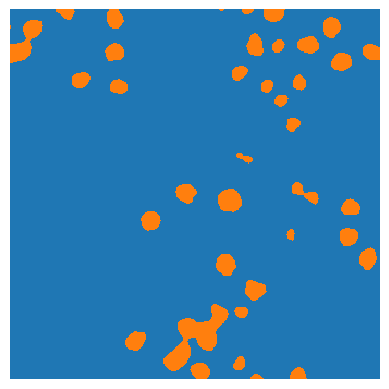

In [3]:
segmented_images = []

for image in images:
    # Apply Otsu threshold
    thresh = threshold_otsu(image)
    initial_mask = image > thresh

    # Perform Random Walker segmentation
    markers = np.zeros(image.shape, dtype=np.uint)
    markers[image < thresh * 0.5] = 1
    markers[image > thresh * 1.5] = 2
    segmented = random_walker(image, markers, beta=10, mode='bf')
    segmented_images.append(segmented)

print(f"Segmented {len(segmented_images)} images.")
stackview.imshow(segmented_images[0])

## 4. Extract features from segmented images
Using region properties to extract features like area, perimeter, eccentricity, etc.

In [4]:
features_list = []
for image, segmented in zip(images, segmented_images):
    props = regionprops_table(segmented, intensity_image=image,
                             properties=['label', 'area', 'perimeter', 'eccentricity', 
                                         'mean_intensity', 'solidity'])
    features_list.append(pd.DataFrame(props))

all_features = pd.concat(features_list, ignore_index=True)
display(all_features.head())

,label,area,perimeter,eccentricity,mean_intensity,solidity
0,1,107150.0,3374.341413,0.213448,4.517228,0.926903
1,2,8450.0,2091.008368,0.681828,100.837396,0.091626
2,1,107202.0,3249.624638,0.227464,3.043171,0.927353
3,2,8398.0,1982.883476,0.671545,107.572636,0.077322
4,1,100082.0,4950.715221,0.119784,9.496403,0.865761


## 5. Visualize relationships between extracted features
Using pairplots to visualize the relationships between extracted features

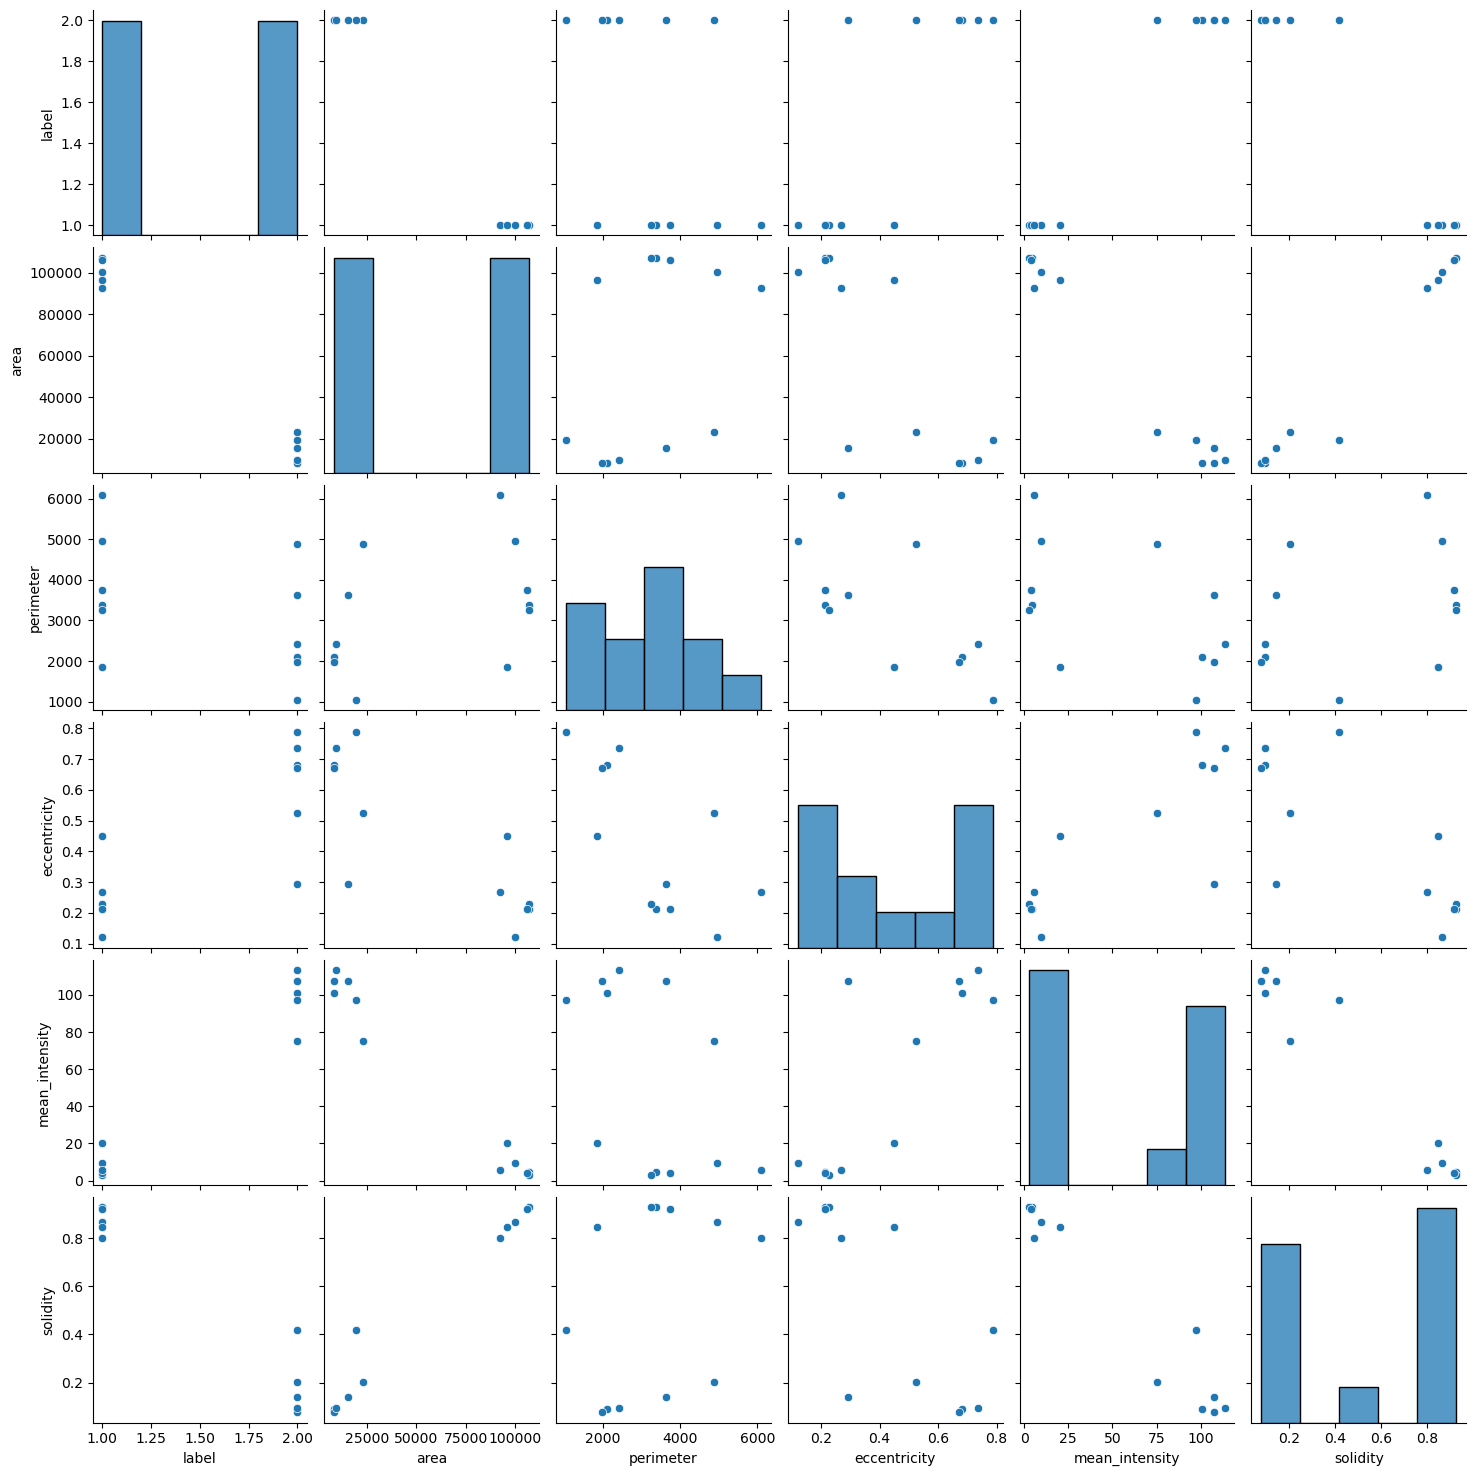

In [5]:
sns.pairplot(all_features)
plt.show()

## 6. Identify which features are strongly correlated
Using correlation matrix to identify relationships between features.

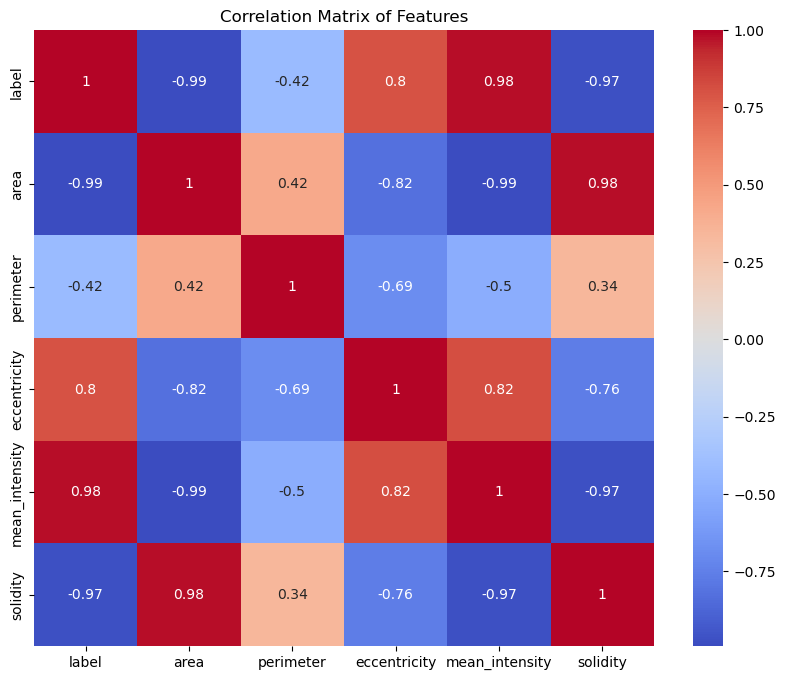

In [6]:
correlation_matrix = all_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

## 7. Save segmentation results and feature data
Saving the segmented images and the features extracted from these images.

In [7]:
output_segmented_folder = './segmented_results/'
output_feature_file = './extracted_features.csv'

os.makedirs(output_segmented_folder, exist_ok=True)

for i, segmented in enumerate(segmented_images):
    tiff.imwrite(os.path.join(output_segmented_folder, f'segmented_{i}.tif'), segmented)

all_features.to_csv(output_feature_file, index=False)
print(f'Saved segmented images in {output_segmented_folder}')
print(f'Saved features to {output_feature_file}')

Saved segmented images in ./segmented_results/
Saved features to ./extracted_features.csv


## 8. Measure the quality of segmentation results
Using the Jaccard index to measure the quality of the segmentation.

In [8]:
jaccard_indices = []
for ref_lbl, seg_lbl in zip(labels, segmented_images):
    ji = metrics.jaccard_index_sparse(ref_lbl, seg_lbl)
    jaccard_indices.append(ji)

print('Jaccard indices for each image:')
print(jaccard_indices)

Jaccard indices for each image:
[0.025042131780712396, 0.027649704225359728, 0.007927342488261635, 0.014594467347979723, 0.010806333529003656, 0.008260193442976196]


## 9. Setup reproducible software environment
Using a requirements.txt file to ensure that the software environment can be reproduced.

### Installation Instructions
1. Clone the repository
2. Install required dependencies using pip
`pip install -r requirements.txt`


In [9]:
!pip freeze > requirements.txt
print('Saved current environment to requirements.txt')

Saved current environment to requirements.txt


## 10. Document the workflow
### User Guide
1. Place the images and corresponding label images in the specified folders.
2. Run the notebook cells sequentially to process the images.

### Documentation of Used Data
* Image set BBBC007v1, version 1 (Jones et al., 2005), available from the Broad Bioimage Benchmark Collection (Ljosa et al., 2012).

### Explanation of Used Algorithms
* Random Walker Segmentation: An algorithm that determines the partitioning of images by simulating random walks on the image.
* Otsu's Method: A global thresholding technique that maximizes the inter-class variance.
* Region Properties Extraction: Uses the regionprops_table function from skimage to extract various features like area, perimeter, and mean intensity.